# Default on credit card prediction (SVM) 

Let's introduce at first the dataset that would be used in this mini-project. (You'll find the source at the Read-me of the repo). 

So let's visualize this dataset and define attributes as we go on. 

In [2]:
import numpy as np
import pandas as pd
from sklearn import svm, datasets
from pylab import *
from sklearn.metrics import confusion_matrix

In [3]:
input_file = "C:/Users/YsfEss/Desktop/UCI_Credit_Card.csv"
df = pd.read_csv(input_file, header = 0)
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0       0.0                           1  
1    1000.0       0.0    2000.0                           1  
2    1000.0    1000.0    5000.0                           0  
3    1100.0    1069.0    1000.0                           0  
4    9000.0     689.0     679.0                           0  

[5 rows x 25 columns]

There is 25 attributes for each client, but we will be interested in particular in 12 attributes (11 predictors & 1 output) for building our model. The features used for the rest of this tutorial are: 


**1- ID: ID of each client** (Won't be used as feature obviously, I left it for visualization purposes only)

**2- LIMIT_BAL: Amount of given credit in NT dollars**

**3- SEX: Gender (1=male, 2=female)**

**4- EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)**

**5- MARRIAGE: Marital status (1=married, 2=single, 3=others)**

**6- AGE: Age in years**

for i [0,6]

**(7-12)- PAY_i: Repayment status in i+9 month, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)**

**default.payment.next.month: Default payment (1=yes, 0=no)**


In [4]:
features=df.columns
features=list(features)
features=features[0:12]+[features[len(features)-1]]

In [5]:
df1=df[features]
df1.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  default.payment.next.month  
0     -2     -2                           1  
1      0      2                           1  
2      0      0                           0  
3      0      0                           0  
4      0      0                           0

Let's make a plot of some of the obseravtion based only on LIMIT_BAL and AGE, just for visualization sake.

It's clear that no pattern is likely to appear using only these two features, but let's just see how data points are spread using these two. 

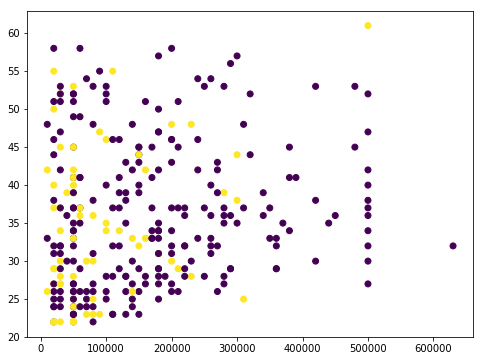

In [5]:
%matplotlib inline
f=df1.sample(frac=0.01)
X=f[['LIMIT_BAL','AGE']]
y=f['default.payment.next.month']
plt.figure(figsize=(8, 6))
plt.scatter(X['LIMIT_BAL'], X['AGE'], c=y.astype(np.float))
plt.show()

Okay, the first big remark we might have just by looking at the dataset is that it needs feature scaling for the qualitative ones, since **LIMIT_BAL** is in tens of thousands scale and the **AGE** is in its smaller range. We will mainly devide these attributes by a dispersion  measure standard deviation for example.

In the other hand qualitative attributes are somewhat blurry, so let's pre-process the ones that needs some tweaking.

First, the **SEX** attribute {1=male, 2=female} needs some recoding so we'll call it **FEMALE** and has True and False values.

Secondly, **MARRIAGE** will also now take values of True and False. 

The rest of attributes are good as they are currently coded.



In [6]:
mean1=float(np.mean(df1['LIMIT_BAL']))
mean2=float(np.mean(df1['AGE']))

In [7]:
df1['LIMIT_BAL']=df1['LIMIT_BAL']/mean1
df1['AGE']=df1['AGE']/mean2
df1['SEX']=df1['SEX'].replace(1,False)
df1['SEX']=df1['SEX'].replace(2,True)

C:\Users\YsfEss\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\YsfEss\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\YsfEss\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

In [8]:
df1.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  \
0   1   0.119414    1          2         1  0.676333      2      2     -1   
1   2   0.716485    1          2         2  0.732694     -1      2      0   
2   3   0.537364    1          2         2  0.958138      0      0      0   
3   4   0.298535    1          2         1  1.042679      0      0      0   
4   5   0.298535    0          2         1  1.606290     -1      0     -1   

   PAY_4  PAY_5  PAY_6  default.payment.next.month  
0     -1     -2     -2                           1  
1      0      0      2                           1  
2      0      0      0                           0  
3      0      0      0                           0  
4      0      0      0                           0

Now that we got that out of the way, let's carry on to the train/test data splitting.

This time since I want to focuse more on the confusion matrix, post model generating analysis and handeling the skewed data set, I'll just use the 70/30.

What makes this dataset unbalanced? Well it is only normal that the number of defaulters would be very smaller than the number of non-defaulters, otherways Taiwan Banks are doing something really wrong. 

So let's confirm this hypothesis.

In [9]:
print('The percentage of defaulters in the dataset is: ',100*len(df1.loc[df1['default.payment.next.month']==1])/30000,'%')

The percentage of defaulters in the dataset is:  22.12 %


Not very small portion but still unbalanced.

So let's prepare the two train/test datasets.

In [10]:
dfShuf=df1.sample(frac=1)

In [11]:
train=dfShuf[0:21000]
test=dfShuf[21000:30000]

In [12]:
DepVar=features[1:len(features)-1]
IndeVar=features[len(features)-1]
X=train[DepVar]
y=train[IndeVar]

In [13]:
X

LIMIT_BAL  SEX  EDUCATION  MARRIAGE       AGE  PAY_0  PAY_2  PAY_3  \
9017    1.074727    1          2         1  1.437207      2      2      0   
1036    0.895606    0          1         2  0.648152      0      0      0   
27917   1.074727    1          1         2  0.817235     -2     -2     -2   
1714    0.119414    1          1         2  0.732694      1     -2     -1   
20555   0.358242    0          1         2  0.789055      0      0      2   
13517   0.955313    0          2         2  0.676333      0      0      0   
11278   1.552384    0          1         2  0.845416      0      0      0   
5272    0.835899    0          3         1  0.901777      0      0      0   
7963    0.955313    0          3         1  1.296304     -1     -1     -1   
25300   0.298535    1          1         2  0.704513      0      0      0   
29667   0.656778    0          2         2  1.070860      3      2      2   
5382    0.238828    1          2         1  1.070860      0      0      0   
18329   0.417950    1          2         2  0.648152      0      0      0   
27741   0.179121    1          3         2  0.619972      0      0      0   
23639   1.015020    1          2         1  0.986318      1     -2     -2   
28919   1.074727    1          1         1  1.127221      0     -1      0   
12360   1.850920    1          2         1  1.042679     -2     -2     -1   
22899   0.776192    1          3         1  1.324485     -1      2      2   
25826   3.045061    1          2         1  1.070860      0      0      0   
3420    2.507697    1          2         2  0.817235      0      0      0   
28970   1.492677    1          1         1  1.127221      1      2      0   
5482    0.119414    1          2         1  0.760874      0      0     -1   
2063    0.835899    0          1         2  1.549929      0      0      0   
24973   0.119414    0          2         2  0.986318      2      2      3   
29733   1.791212    0          2         1  1.042679     -2     -2     -1   
23850   1.791212    1          2         2  1.606290     -1     -1     -1   
13918   0.776192    0          1         2  0.817235      0      0      0   
21665   0.597071    1          1         2  0.648152     -1     -1     -1   
7650    1.194142    0          3         2  1.014499     -2     -2     -2   
6856    2.149455    1          1         2  0.817235     -2     -2     -2   
...          ...  ...        ...       ...       ...    ...    ...    ...   
9300    0.776192    1          1         2  0.789055     -2     -2     -2   
27198   0.179121    0          2         1  0.986318      1     -1     -1   
454     0.477657    0          2         2  1.183582      0      0      0   
655     1.671798    0          2         1  1.099040     -2     -2     -2   
94      0.358242    1          2         2  0.648152      0      0      0   
4216    1.074727    0          2         2  0.676333     -2     -2     -2   
24015   0.477657    0          2         2  0.704513     -1     -1     -1   
16120   0.298535    1          2         1  1.099040      0      0      0   
12206   0.179121    0          2         1  1.014499      1      3      2   
16765   0.179121    0          2         2  1.042679      0      0      0   
15896   0.119414    1          2         2  0.704513      0      0      0   
21129   1.432970    0          2         1  1.042679      1      2      0   
2971    0.298535    1          1         2  0.845416      0      0      0   
15769   0.179121    1          2         2  0.676333     -2     -2     -2   
17406   2.089748    1          3         1  1.014499      0      0      0   
19884   2.985354    1          1         2  0.873596      1     -1     -1   
22996   2.985354    1          1         1  1.099040     -2     -2     -2   
5661    1.612091    1          2         1  1.183582     -1     -1      2   
8355    1.552384    1          1         1  1.014499      0      0      0   
1042    0.656778    1          2         1  1.183582      0      0      0   
131

In [14]:
#Let's start with a linear kernel
svc=svm.SVC(kernel='linear', C=1.0)

In [15]:
model=svc.fit(X,y)

In [16]:
predictions=model.predict(test[DepVar])

In [17]:
print('The SVM model with linear kernel accuracy is: ',100*list(predictions==test[IndeVar]).count(True)/len(test),'%')

The SVM model with linear kernel accuracy is:  81.07777777777778 %


Not the best thing in the world, plus the null model that always predict the client won't default would get a 77.88% accuracy, so our current model only slightly does better than the null model, this calls for further tweaks to the model, the kernel for example.

So what we will do next is try all other kernels provided by scikit-learn SVC, which are: polynomial, rbf, sigmoid, precomputed.  

In [18]:
#Let's start with a polynomial kernel
svc1=svm.SVC(kernel='poly', C=1.0)

In [19]:
model1=svc1.fit(X,y)

C:\Users\YsfEss\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [20]:
predictions1=model1.predict(test[DepVar])
print('The SVM model with polynomial kernel accuracy is: ',100*list(predictions1==test[IndeVar]).count(True)/len(test),'%')

The SVM model with polynomial kernel accuracy is:  81.42222222222222 %


More accurate..but not with so much.

In [21]:
#Let's start with a rbf kernel
svc2=svm.SVC(kernel='rbf', C=1.0)

In [22]:
model2=svc2.fit(X,y)

C:\Users\YsfEss\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [23]:
predictions2=model2.predict(test[DepVar])
print('The SVM model with rbf kernel accuracy is: ',100*list(predictions2==test[IndeVar]).count(True)/len(test),'%')

The SVM model with rbf kernel accuracy is:  82.25555555555556 %


In [24]:
#Let's start with a sigmoid kernel
svc3=svm.SVC(kernel='sigmoid', C=1.0)

In [25]:
model3=svc3.fit(X,y)

C:\Users\YsfEss\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [26]:
predictions3=model3.predict(test[DepVar])
print('The SVM model with sigmoid kernel accuracy is: ',100*list(predictions3==test[IndeVar]).count(True)/len(test),'%')

The SVM model with sigmoid kernel accuracy is:  65.31111111111112 %


So using rbf kernel gives best performance, and the sigmoid kernel performs very bad (worst than null model), although 82% of accuracy is still a bit lower than what we expect, so for now let's investigate the confusion matrix for the best model to see what kind of mistakes it does.

Note that on the rows the real values and on the columns the predicted values.

In [27]:
pd.DataFrame(data=confusion_matrix(test[IndeVar],predictions2),columns=[0,1],index=[0,1])

0    1
0  6681  335
1  1262  722

Okay, for the rbf kernel trained model we have a precision of: $precision =\frac{tp}{tp+fp}= 68$% and a recall of: $recall =\frac{tp}{tp+fn}= 36$%. So this is really not satisfactory from a bank requirement perspective.

And the $F1$ score is: $F1 = \frac{2PR}{P+R}=0.46$

In [28]:
pd.DataFrame(data=confusion_matrix(test[IndeVar],predictions1),columns=[0,1],index=[0,1])

0    1
0  6707  309
1  1363  621

For the polynomial kernel trained model we have a precision of: $precision =\frac{tp}{tp+fp}= 67$% and a recall of: $recall =\frac{tp}{tp+fn}= 31$%. So this is coherent with the full accuracy results. $F1 = \frac{2PR}{P+R}=0.42$

In [29]:
pd.DataFrame(data=confusion_matrix(test[IndeVar],predictions),columns=[0,1],index=[0,1])

0    1
0  6809  207
1  1496  488

Finally for the linear model, we have a precision of: $precision =\frac{tp}{tp+fp}= 70$% and a recall of: $recall =\frac{tp}{tp+fn}= 25$%. 

And the $F1$ score is: $F1 = \frac{2PR}{P+R}=0.36$